## Importamos librerías

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

#from deap import algorithms
from deap import base  # Estructura que permite agrupar todos los componentes de nuestro algoritmo en una misma bolsa
from deap import creator  # Permite crear los componentes de nuestro algoritmo
from deap import tools  # Contiene funciones precargadas

## Funciones auxiliares

In [2]:
#=================================
def bin():
    '''
    Esta función genera un bit al azar.
    '''
    if random.random() > 0.5:
        return 1
    else:
        return 0
#=================================


#=================================
def bin2dec(ind, low, high):
    '''
    Esta función permite convertir un número binario
    (lista de "0" y "1") en un valor decimal, dados
    los límites inferior y superior tomados para la
    conversión.
    low: Límite inferior del rango a barrer
    high: Límite superior del rango a barrer
    '''

    N = len(ind)  # Número binario [vector de 0's y 1's]

    x = 0
    for k,i in enumerate(ind[::-1]):
        x += (i * 2**k)

    x = low + ((high-low)/ (2**N)) * x

    return x
#================================


#=================================
def fitness(x):
    '''
    Función de aptitud empleada por nuestro algoritmo.
    '''
    y = -x * math.sin(abs(x)**0.5)
    # -x * math.sin(math.sqrt(abs(x)))
    
    return y
#=================================


#=================================
def evaluate(ind, lb, ub):
    '''
    Esta función toma un cromosoma/individuo y evaluá el fitness.
    Para eso, primero hace la conversión GENOTIPO --> FENOTIPO,
    y luego evalúa la función de fitness especificada.

    lb: Límite inferior del rango a barrer
    ub: Límite superior del rango a barrer
    '''
    x = bin2dec(ind, low=lb, high=ub)
    
    y = fitness(x)
    
    return (y, )
#=================================


#=================================
def mutation(ind, p):
    '''
    Esta función recorre el cromosoma y evalúa, para cada gen,
    si debe aplicar el operador de mutación.
    '''
    #individuo = []
    
    #for i in ind:
    #    if random.random() < p:
    #        individuo.append(abs(i-1))
    #    else:
    #        individuo.append(i)
    #return individuo

    return [abs(i-1) if random.random() < p else i for i in ind]
#=================================

## Inicializamos parámetros del experimento

In [3]:
IND_SIZE = 10  # Cantidad de genes en el cromosoma
LB = -512  # Límite inferior del rango a evaluar
UB = 512  # Límite superior del rango a evaluar

POP_SIZE = 30  # Cantidad de individuos en la población
PM = 0.001 # 1./IND_SIZE  # Probabilidad de mutación [aproximadamente 1 gen por cromosoma]
PX = 0.9  # Probabilidad de cruza
GMAX = 200  # Cantidad máxima de generaciones que se ejecutará el algoritmo

## Creamos los componentes del algoritmo

**Documentación**: https://deap.readthedocs.io/en/master/api/creator.html

In [4]:
# CREAMOS LA FUNCION DE FITNESS
# Esta función tiene "1 OBJETIVO" a "MINIMIZAR"
creator.create("Fitness",  # Nombre con el que se registra el componente
               base.Fitness,  # Clase de la que hereda
               weights=(-1.0,))

#---------------------

# CREAMOS EL CONSTRUCTOR DE INDIVIDUOS
creator.create("Individual", # Nombre con el que se registra el componente
               list,  # Clase de la que hereda [Tipo de contenedor en este caso]
               fitness=creator.Fitness)  # Asignamos un método para evaluar el fitness del individuo

#creator.create("Individual",  # Nombre con el que se registra el componente
#               array.array,  # Clase de la que hereda [Tipo de contenedor en este caso]
#               typecode="d",
#               fitness=creator.Fitness) # Asignamos un método para evaluar el fitness del individuo

#creator.create("Individual",  # Nombre con el que se registra el componente
#               numpy.ndarray,  # Clase de la que hereda [Tipo de contenedor en este caso]
#               fitness=creator.Fitness)  # Asignamos un método para evaluar el fitness del individuo

## REGISTRAMOS COMPONENTES

In [5]:
toolbox = base.Toolbox()

#---------------------

# DEFINIMOS COMO CONSTRUIR UN GEN
toolbox.register("attribute",  # Nombre con el que se registra el componente
                 bin)  # Función asociada a ese componente

#---------------------

# DEFINIMOS COMO CONSTRUIR UN INDIVIDUO/CROMOSOMA
toolbox.register("individual",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 creator.Individual,  # ...
                 toolbox.attribute,  # Función para construir cada gen
                 n=IND_SIZE)  # Número de genes del cromosoma/individuo (se repetirá la función construir gen)

#---------------------

# DEFINIMOS COMO CONSTRUIR LA POBLACION
toolbox.register("population",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 list,
                 toolbox.individual)

#---------------------

# DEFINIMOS COMO REALIZAR LA CRUZA
toolbox.register("mate",  # Nombre con el que se registra el componente
                 tools.cxTwoPoint)  # 

#---------------------

# DEFINIMOS COMO REALIZAR LA MUTACION
toolbox.register("mutate",  # Nombre con el que se registra el componente
                 mutation,  # Método de mutación (definido como función más arriba)
                 p=PM)  # Parámetro que usa la mutación

#toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
#toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)

#---------------------

# DEFINIMOS COMO REALIZAR LA SELECCION DE INDIVIDUOS
toolbox.register("select",  # Nombre con el que se registra el componente
                 tools.selTournament,  # Método usado para selección [selRoulette | selTournament | ...]
                 tournsize=3)  # Parámetro que usa el torneo

#---------------------

# DEFINIMOS COMO EVALUAR LA APTITUD DE LOS INDIVIDUOS
toolbox.register("evaluate",  # Nombre con el que se registra el componente
                 evaluate,
                lb=LB,
                ub=UB)

## Definimos las estadísticas a calcular

In [6]:
# EXTRAEMOS EL FITNESS DE TODOS LOS INDIVIDUOS
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)

# EXTRAEMOS EL TAMAÑO DE TODOS LOS INDIVIDUOS
stats_size = tools.Statistics(key=len)

# EXTRAEMOS EL TAMAÑO DE TODOS LOS INDIVIDUOS
stats_active_genes = tools.Statistics(key=lambda ind: np.sum(ind))

mstats = tools.MultiStatistics(fitness=stats_fit,
                               size=stats_size,
                               genes=stats_active_genes)

mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# INICIALIZAMOS UN LOGGER
logbook = tools.Logbook()

In [7]:
#================================================
# INICIALIZAMOS LA POBLACIÓN
#================================================
pop = toolbox.population(n=POP_SIZE)  # Inicializamos una población
#================================================


#================================================
# EVALUAMOS EL FITNESS DE LA POBLACION
#======================================
fitnesses = list(map(toolbox.evaluate, pop))
#================================================


#================================================
# ASIGNAMOS A CADA INDIVIDUO SU FITNESS
#========================================
for ind,fit in zip(pop, fitnesses):
    ind.fitness.values = fit  # Guardamos el fitness para cada individuo (en el individuo)
#================================================

records = mstats.compile(pop)
logbook.record(gen=0, **records)

In [8]:
#################################################################################
# COMENZAMOS LA EVOLUCION
################################

for g in range(1,GMAX):#tqdm(range(GMAX)):

    #================================================
    # SELECCIONAMOS INDIVIDUO ELITE
    #================================
    idx_elite = np.argmin(fitnesses)  # Si maximizamos, hay que usar ".argmax()"
    elite = toolbox.clone(pop[idx_elite])
    del elite.fitness.values
    #================================================

     #================================================
    # HACEMOS UNA COPIA DE LA POBLACION ACTUAL
    #==========================================
    parents = toolbox.select(pop, POP_SIZE)  # Seleccionamos individuos para alcanzar
                                               # el tamaño de la población
    
    offspring = list(map(toolbox.clone, pop))  # Clonamos para tener nuevos individuos
                                                     # (contenedores independientes)
    #================================================


    #================================================
    # REALIZAMOS LA CRUZA DE LOS PADRES
    #====================================
    for i in range(POP_SIZE//2):
        parent1 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        parent2 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        
        if random.random() < PX:
            childs = toolbox.mate(parent1, parent2)
        else:
            childs = (parent1, parent2)
        
        offspring[2*i] = childs[0]
        offspring[2*i+1] = childs[1]
    #================================================



    #================================================
    # MUTAMOS LOS HIJOS
    #=================================
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    #================================================
    
    
    #================================================
    # EVALUAMOS EL FITNESS
    # Y SE LO ASIGNAMOS A CADA INDIVIDUO
    #======================================
    offspring[0] = elite

    fitnesses = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit
    #================================================

    
    #================================================
    # CONSTRUIMOS LA NUEVA POBLACION
    #================================
    pop = toolbox.clone(offspring)
    #================================================

    
    #================================================
    # CALCULAMOS ESTADÏSTICAS
    #============================
    records = mstats.compile(pop)
    logbook.record(gen=g, **records)

    if (g%50 == 0):
        print('='*79)
        print('FITNES: ', records['fitness'])
        print('SIZE: ', records['size'])
        print('GENES: ', records['genes'])
    #================================================

FITNES:  {'avg': -418.9827640161442, 'std': 1.1368683772161603e-13, 'min': -418.9827640161443, 'max': -418.9827640161443}
SIZE:  {'avg': 10.0, 'std': 0.0, 'min': 10, 'max': 10}
GENES:  {'avg': 6.0, 'std': 0.0, 'min': 6, 'max': 6}
FITNES:  {'avg': -418.9827640161442, 'std': 1.1368683772161603e-13, 'min': -418.9827640161443, 'max': -418.9827640161443}
SIZE:  {'avg': 10.0, 'std': 0.0, 'min': 10, 'max': 10}
GENES:  {'avg': 6.0, 'std': 0.0, 'min': 6, 'max': 6}
FITNES:  {'avg': -418.9827640161442, 'std': 1.1368683772161603e-13, 'min': -418.9827640161443, 'max': -418.9827640161443}
SIZE:  {'avg': 10.0, 'std': 0.0, 'min': 10, 'max': 10}
GENES:  {'avg': 6.0, 'std': 0.0, 'min': 6, 'max': 6}


## Graficamos la solución

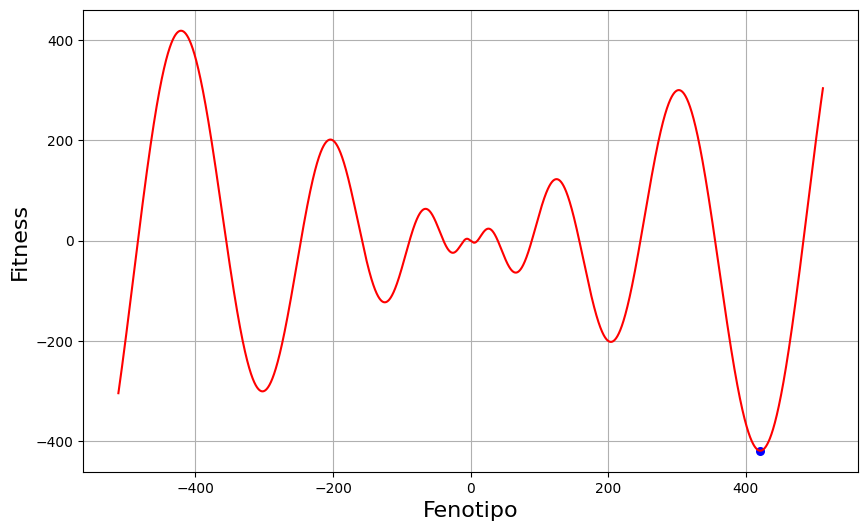

In [9]:
#====================================================
# PLOT RESULTS
#===================
fig, ax = plt.subplots(1, 1, figsize=(10,6))

delta = 0.01
X = np.arange(LB, UB+delta, delta)
Y = [fitness(x) for x in X]


ax.plot(X, Y, '-r')
ax.scatter(bin2dec(elite,LB,UB), evaluate(elite, LB, UB), s=30, c='blue')
ax.grid(True)
ax.set_xlabel('Fenotipo', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
plt.show()

## Graficamos la evolución del fitness

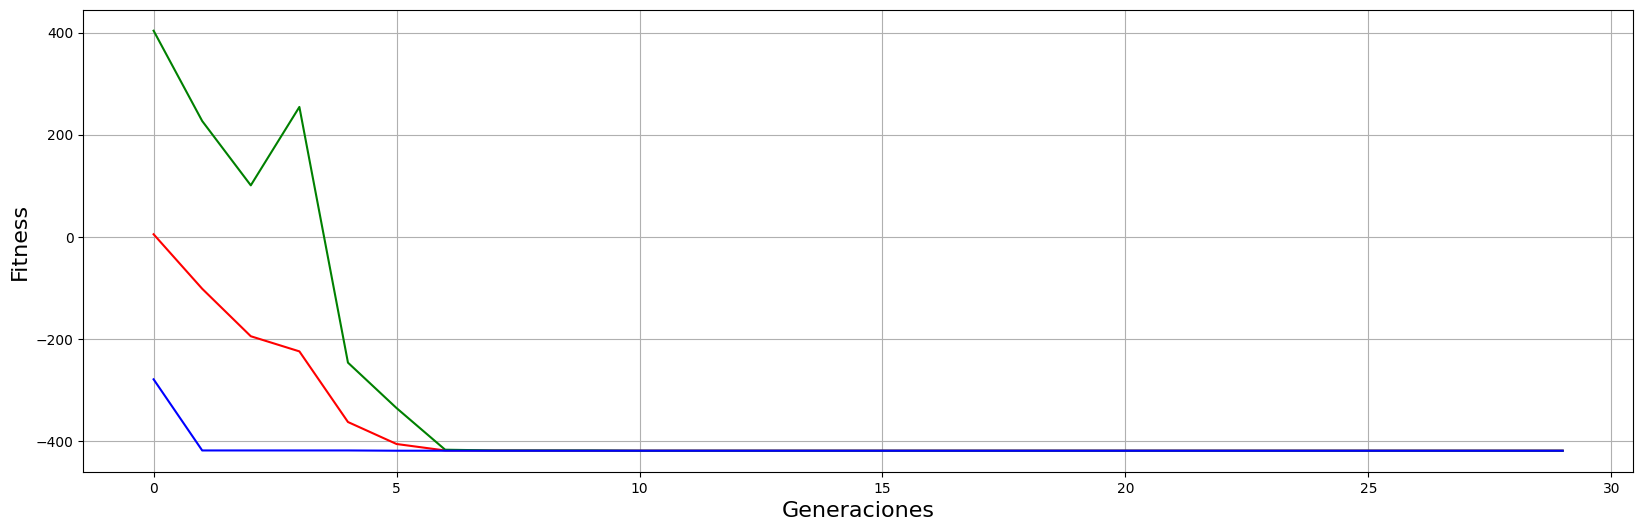

In [10]:
f_avg = [f['avg'] for f in logbook.chapters['fitness']]  # Extraemos fitness promedio a lo largo de las épocas
f_max = [f['max'] for f in logbook.chapters['fitness']]  # Extraemos fitness máximo a lo largo de las épocas
f_min = [f['min'] for f in logbook.chapters['fitness']]  # Extraemos fitness mínimo (elite) a lo largo de las épocas

N = 30 if GMAX > 30 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), f_avg[:N], '-r')
ax.plot(range(N), f_max[:N], '-g')
ax.plot(range(N), f_min[:N], '-b')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.grid(True)